In [3]:
!pip install gdown

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=cf96e7aa6f1cbdbf272596df8faa5364be423531e8ce1ca9137452056c96f752
  Stored in directory: c:\users\juanl\appdata\local\pip\cache\wheels\e2\62\1e\926d1ebe7b1e733c78d627fd288d01b83feaf67efc06e0e4c3
Successfully built gdown


In [4]:
import gdown
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [10]:
gdown.download('https://drive.google.com/file/d1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3', 'datasets/london_bike_sharing.csv')

Downloading...
From: https://drive.google.com/file/d1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: D:\master\edemMDA\Analitica_De_Datos\datasets\london_bike_sharing.csv
2.96kB [00:00, 2.96MB/s]


'datasets/london_bike_sharing.csv'

In [11]:
df = pd.read_csv('datasets/london_bike_sharing_2.csv',
                parse_dates=['timestamp'],
                index_col='timestamp')
df.shape

(17414, 9)

In [12]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [13]:
df.dtypes

cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [14]:
# Create new features from the time field
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['timestamp'] = df.index
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['dayofmonth'] = df['timestamp'].dt.day
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    
    X = df[['t1',	'is_holiday',	'is_weekend',	'season','hour','dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [15]:
print(df)

                      cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                              
2015-01-04 00:00:00   182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00   138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00   134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00    72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00    47  2.0  0.0   93.0         6.5           1.0   
...                   ...  ...  ...    ...         ...           ...   
2017-01-03 19:00:00  1042  5.0  1.0   81.0        19.0           3.0   
2017-01-03 20:00:00   541  5.0  1.0   81.0        21.0           4.0   
2017-01-03 21:00:00   337  5.5  1.5   78.5        24.0           4.0   
2017-01-03 22:00:00   224  5.5  1.5   76.0        23.0           4.0   
2017-01-03 23:00:00   139  5.0  1.0   76.0        22.0           2.0   

                     is_holiday  is_weekend  season  
timestamp

In [16]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [17]:
TRAIN_SPLIT=14000
multi_data = df[['cnt','t1','is_holiday','is_weekend','season']]
multi_data.head()

,cnt,t1,is_holiday,is_weekend,season
timestamp,,,,,
2015-01-04 00:00:00,182,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,1.0,3.0


In [18]:
# Creating and splitting the data
multi_data_train = multi_data[:TRAIN_SPLIT]
multi_data_test = multi_data[TRAIN_SPLIT:]
X_train, y_train = create_features(multi_data_train, label='cnt')
X_test, y_test = create_features(multi_data_test, label='cnt')

<ipython-input-14-15563569986c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = df.index
<ipython-input-14-15563569986c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['timestamp'].dt.hour
<ipython-input-14-15563569986c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [19]:
X_train.head()

,t1,is_holiday,is_weekend,season,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
timestamp,,,,,,,,,,,
2015-01-04 00:00:00,3.0,0.0,1.0,3.0,0,6,1,2015,4,4,1
2015-01-04 01:00:00,3.0,0.0,1.0,3.0,1,6,1,2015,4,4,1
2015-01-04 02:00:00,2.5,0.0,1.0,3.0,2,6,1,2015,4,4,1
2015-01-04 03:00:00,2.0,0.0,1.0,3.0,3,6,1,2015,4,4,1
2015-01-04 04:00:00,2.0,0.0,1.0,3.0,4,6,1,2015,4,4,1


In [20]:
y_train.head()


timestamp
2015-01-04 00:00:00    182
2015-01-04 01:00:00    138
2015-01-04 02:00:00    134
2015-01-04 03:00:00     72
2015-01-04 04:00:00     47
Name: cnt, dtype: int64

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

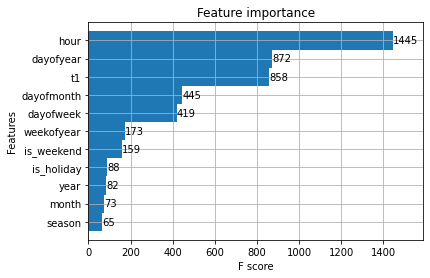

In [22]:
# Plot the most important features
_= plot_importance(reg, height=1)

In [23]:
multi_data_test['Prediction'] = reg.predict(X_test)

<ipython-input-23-b71fc5982232>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_data_test['Prediction'] = reg.predict(X_test)


<AxesSubplot:xlabel='timestamp'>

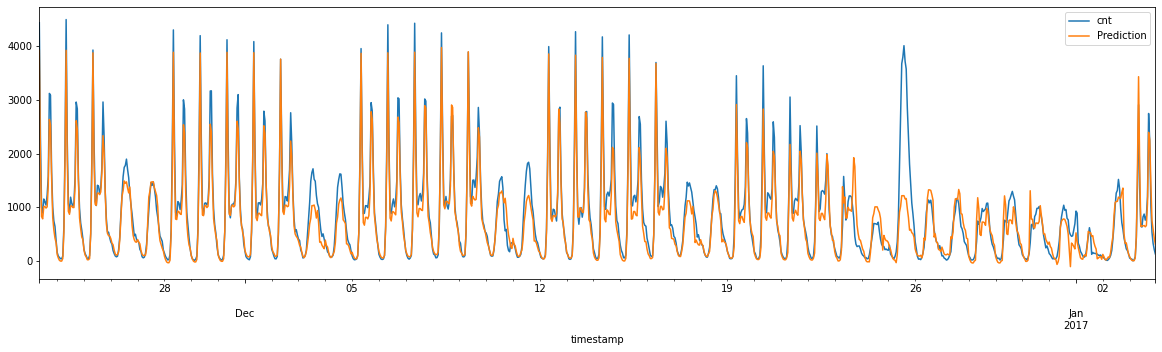

In [24]:
multi_data_test[-1000:][['cnt','Prediction']].plot(figsize=(20, 5))

In [25]:
mean_squared_error(y_true=multi_data_test['cnt'],
                   y_pred=multi_data_test['Prediction'])

115220.41120906977

In [26]:
mean_absolute_error(y_true=multi_data_test['cnt'],    
                    y_pred=multi_data_test['Prediction'])

211.3113324144952

In [27]:
y_true = multi_data_test['cnt']

In [28]:
y_pred = multi_data_test['Prediction']

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [31]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(rmse)

339.44132218848927
